In [ ]:
# Install required packages
!pip install transformers datasets peft accelerate bitsandbytes optuna wandb evaluate scikit-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.2 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import evaluate
import optuna
import wandb
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)
from transformers import BitsAndBytesConfig
import gc

In [ ]:
torch.cuda.empty_cache()
gc.collect()


30

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("Loading dataset...")

Loading dataset...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path_prefix = "/content/drive/MyDrive/Banking77_Project/data/"
data_files = {
    "train": os.path.join(data_path_prefix, "train.csv"),
    "validation": os.path.join(data_path_prefix, "validation.csv"),
    "test": os.path.join(data_path_prefix, "test.csv"),
}

dataset = load_dataset('csv', data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
label_names = sorted(list(set(dataset["train"]["intent"])))
label2id = {label: idx for idx, label in enumerate(label_names)}
id2label = {idx: label for label, idx in label2id.items()}
num_labels = len(label_names)

print(f"Number of labels: {num_labels}")
print(f"Dataset: {dataset}")

Number of labels: 77
Dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'text_cleaned'],
        num_rows: 8002
    })
    validation: Dataset({
        features: ['text', 'intent', 'text_cleaned'],
        num_rows: 2001
    })
    test: Dataset({
        features: ['text', 'intent', 'text_cleaned'],
        num_rows: 3080
    })
})


In [ ]:
# Model and tokenizer setup
model_name = "microsoft/DialoGPT-medium"
print(f"Loading tokenizer and model: {model_name}")

Loading tokenizer and model: microsoft/DialoGPT-medium


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Add pad token if not present (common issue with DialoGPT)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [ ]:
from transformers import GPT2ForSequenceClassification


In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    pad_token_id=tokenizer.eos_token_id  # Set pad token
)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

In [ ]:
lora_config = LoraConfig(
    r=16,  # Rank - can reduce to 8 if memory issues
    lora_alpha=32,
    target_modules=[
        "c_attn",  # DialoGPT/GPT2 specific attention module
        "c_proj"   # DialoGPT/GPT2 specific projection module
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS  # Sequence Classification for PEFT
)

In [ ]:
# Preprocessing function
def preprocess(example):
    # Simple preprocessing for classification
    encoding = tokenizer(
        example['text'],
        truncation=True,
        padding="max_length",
        max_length=128,  # Reasonable length for banking queries
        return_tensors=None
    )

    return encoding

In [ ]:
print("Preprocessing dataset...")
dataset = dataset.map(preprocess, batched=False, remove_columns=['text'])
dataset = dataset.map(lambda e: {"label": [label2id[l] for l in e["intent"]]}, batched=True)
dataset = dataset.remove_columns(['intent'])


Preprocessing dataset...


Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


In [ ]:
def objective(trial):
    # Suggest hyperparameters - more conservative for QLoRA
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16])  # Smaller for memory
    num_epochs = trial.suggest_int("num_train_epochs", 3, 6)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    warmup_steps = trial.suggest_int("warmup_steps", 100, 500)

    try:
        # Create fresh model for each trial
        trial_model = GPT2ForSequenceClassification.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            pad_token_id=tokenizer.eos_token_id
        )

        # Prepare for k-bit training
        trial_model = prepare_model_for_kbit_training(trial_model)

        # Apply PEFT adapter
        trial_model = get_peft_model(trial_model, lora_config)

        # W&B init per trial (uncomment if using)
        # wandb.init(
        #     project="banking77-qlora-dialogpt",
        #     name=f"trial_{trial.number}",
        #     reinit=True,
        #     config={
        #         "learning_rate": learning_rate,
        #         "batch_size": batch_size,
        #         "num_epochs": num_epochs,
        #         "weight_decay": weight_decay,
        #         "warmup_steps": warmup_steps,
        #         "model": model_name
        #     }
        # )

        # Training arguments optimized for T4
        training_args = TrainingArguments(
            output_dir=f"./results/trial_{trial.number}",
            eval_strategy="epoch",
            save_strategy="no",  # Save space
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            weight_decay=weight_decay,
            warmup_steps=warmup_steps,
            logging_dir="./logs",
            logging_steps=50,
            dataloader_pin_memory=False,  # Reduce memory usage
            gradient_checkpointing=True,  # Reduce memory at cost of speed
            fp16=True,  # Use mixed precision
            # report_to=["wandb"]  # Uncomment if using W&B
            report_to=[]  # No reporting to save resources
        )

        trainer = Trainer(
            model=trial_model,
            args=training_args,
            train_dataset=dataset["train"],
            eval_dataset=dataset["validation"],
            processing_class=tokenizer,  # Updated parameter name
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )

        trainer.train()
        eval_results = trainer.evaluate()

        # Clean up
        del trainer
        del trial_model
        torch.cuda.empty_cache()
        gc.collect()

        # Log to W&B if using
        # wandb.log(eval_results)
        # wandb.finish()

        return eval_results["eval_accuracy"]

    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        # wandb.finish()  # Uncomment if using W&B
        torch.cuda.empty_cache()
        gc.collect()
        return 0.0

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)  # Reduced for faster execution


[I 2025-08-25 07:06:08,288] A new study created in memory with name: no-name-20c24ac8-933d-4ef8-9199-9bfe44d24718
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.266800,4.228157,0.037981,0.025404
2,3.992200,3.880849,0.133933,0.104085
3,3.773300,3.705623,0.179910,0.151091


[I 2025-08-25 07:24:47,330] Trial 0 finished with value: 0.17991004497751126 and parameters: {'learning_rate': 1.2453998680673265e-05, 'batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.09871984618739574, 'warmup_steps': 399}. Best is trial 0 with value: 0.17991004497751126.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.471800,3.121184,0.306347,0.271513
2,1.677300,1.290898,0.713643,0.700926
3,1.064600,0.854756,0.792104,0.783727
4,0.838700,0.697582,0.828586,0.825518
5,0.766300,0.633750,0.844578,0.842640
6,0.660900,0.613858,0.845577,0.843690


[I 2025-08-25 08:01:17,771] Trial 1 finished with value: 0.8455772113943029 and parameters: {'learning_rate': 3.1661059697440026e-05, 'batch_size': 16, 'num_train_epochs': 6, 'weight_decay': 0.0723627131755134, 'warmup_steps': 238}. Best is trial 1 with value: 0.8455772113943029.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.360800,1.026680,0.744628,0.735087
2,0.691800,0.519526,0.857571,0.855818
3,0.445300,0.424084,0.875562,0.873723
4,0.340400,0.381077,0.889555,0.887924
5,0.280700,0.362939,0.896052,0.895190
6,0.249700,0.353699,0.900050,0.899229


[I 2025-08-25 08:37:47,140] Trial 2 finished with value: 0.9000499750124937 and parameters: {'learning_rate': 8.08042372175477e-05, 'batch_size': 16, 'num_train_epochs': 6, 'weight_decay': 0.029511688207137635, 'warmup_steps': 182}. Best is trial 2 with value: 0.9000499750124937.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.619000,0.559457,0.846077,0.839979
2,0.296500,0.384070,0.911544,0.911427
3,0.145500,0.356684,0.919540,0.919390
4,0.084700,0.340098,0.922539,0.922542


[I 2025-08-25 09:04:23,077] Trial 3 finished with value: 0.9225387306346826 and parameters: {'learning_rate': 0.0004339828956771877, 'batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.06505869488323553, 'warmup_steps': 219}. Best is trial 3 with value: 0.9225387306346826.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.547700,0.582593,0.846577,0.842600
2,0.279700,0.383702,0.911044,0.910645
3,0.145600,0.352741,0.917041,0.917040
4,0.091400,0.330024,0.926037,0.926425


[I 2025-08-25 09:31:00,044] Trial 4 finished with value: 0.9260369815092454 and parameters: {'learning_rate': 0.0004619556744567909, 'batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.09050373302590131, 'warmup_steps': 389}. Best is trial 4 with value: 0.9260369815092454.


In [ ]:
print("Best Trial:")
print(study.best_trial.params)
print(f"Best Accuracy: {study.best_trial.value:.4f}")

Best Trial:
{'learning_rate': 0.0004619556744567909, 'batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 0.09050373302590131, 'warmup_steps': 389}
Best Accuracy: 0.9260


In [ ]:
best_params = study.best_trial.params

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    pad_token_id=tokenizer.eos_token_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)


In [ ]:
final_args = TrainingArguments(
    output_dir="./final_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_steps=best_params["warmup_steps"],
    load_best_model_at_end=True,
    logging_dir="./logs_final",
    logging_steps=50,
    dataloader_pin_memory=False,
    gradient_checkpointing=True,
    fp16=True,
    #report_to=["wandb"]
    report_to=[]
)

In [ ]:
final_trainer = Trainer(
    model=model,
    args=final_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2441184532.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


In [ ]:
print("Training final model...")
final_trainer.train()

Training final model...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.547700,0.582593,0.846577,0.842600
2,0.279700,0.383702,0.911044,0.910645
3,0.145600,0.352741,0.917041,0.917040
4,0.091400,0.330024,0.926037,0.926425


TrainOutput(global_step=4004, training_loss=0.5311224529971847, metrics={'train_runtime': 1568.5092, 'train_samples_per_second': 20.407, 'train_steps_per_second': 2.553, 'total_flos': 7541666479079424.0, 'train_loss': 0.5311224529971847, 'epoch': 4.0})

In [ ]:
print("Evaluating on test set...")
test_results = final_trainer.evaluate(dataset["test"])
print("Final Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Evaluating on test set...


Final Test Results:
eval_loss: 0.3129
eval_accuracy: 0.9351
eval_f1: 0.9350
eval_runtime: 43.5264
eval_samples_per_second: 70.7620
eval_steps_per_second: 8.8450
epoch: 4.0000


In [ ]:
# Save the final model
print("Saving final model...")
final_trainer.save_model("./final_qlora_model")
tokenizer.save_pretrained("./final_qlora_model")

Saving final model...


('./final_qlora_model/tokenizer_config.json',
 './final_qlora_model/special_tokens_map.json',
 './final_qlora_model/chat_template.jinja',
 './final_qlora_model/vocab.json',
 './final_qlora_model/merges.txt',
 './final_qlora_model/added_tokens.json',
 './final_qlora_model/tokenizer.json')

In [ ]:
print("Training completed!")
print(f"Best Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Best Test F1: {test_results['eval_f1']:.4f}")

Training completed!
Best Test Accuracy: 0.9351
Best Test F1: 0.9350


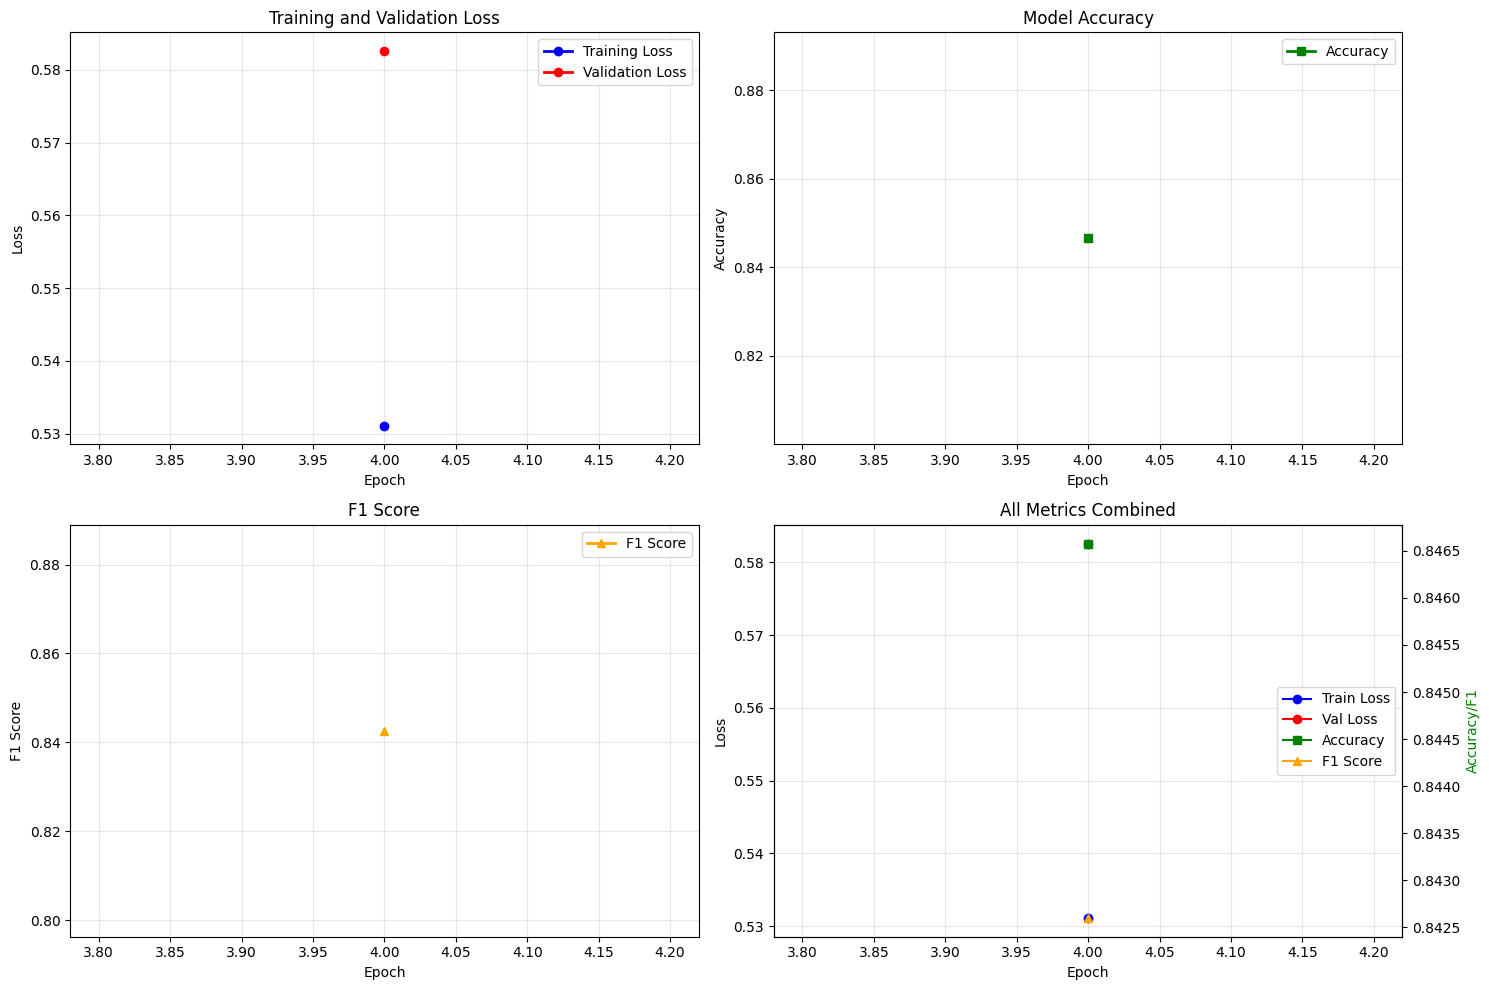

   Epoch  Training_Loss  Validation_Loss  Accuracy  F1_Score
0    4.0       0.531122         0.582593  0.846577    0.8426


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_training_from_trainer(trainer):
    """
    Extract and plot training metrics from trainer object
    """
    # Get log history from trainer
    log_history = trainer.state.log_history

    # Separate training and validation logs
    train_logs = []
    eval_logs = []

    for log in log_history:
        if 'train_loss' in log:
            train_logs.append(log)
        elif 'eval_loss' in log:
            eval_logs.append(log)

    # Extract data
    epochs = []
    train_losses = []
    val_losses = []
    accuracies = []
    f1_scores = []

    for i in range(min(len(train_logs), len(eval_logs))):
        epochs.append(train_logs[i]['epoch'])
        train_losses.append(train_logs[i]['train_loss'])
        val_losses.append(eval_logs[i]['eval_loss'])

        # Handle optional metrics
        accuracies.append(eval_logs[i].get('eval_accuracy', 0))
        f1_scores.append(eval_logs[i].get('eval_f1', 0))

    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Loss curves
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-o', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Accuracy
    ax2.plot(epochs, accuracies, 'g-s', label='Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: F1 Score
    ax3.plot(epochs, f1_scores, 'orange', marker='^', linestyle='-',
             label='F1 Score', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.set_title('F1 Score')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Combined view
    ax4_twin = ax4.twinx()

    # Loss on left y-axis
    line1 = ax4.plot(epochs, train_losses, 'b-o', label='Train Loss')
    line2 = ax4.plot(epochs, val_losses, 'r-o', label='Val Loss')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss', color='black')

    # Metrics on right y-axis
    line3 = ax4_twin.plot(epochs, accuracies, 'g-s', label='Accuracy')
    line4 = ax4_twin.plot(epochs, f1_scores, 'orange', marker='^',
                          linestyle='-', label='F1 Score')
    ax4_twin.set_ylabel('Accuracy/F1', color='green')

    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='center right')
    ax4.set_title('All Metrics Combined')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return DataFrame for analysis
    return pd.DataFrame({
        'Epoch': epochs,
        'Training_Loss': train_losses,
        'Validation_Loss': val_losses,
        'Accuracy': accuracies,
        'F1_Score': f1_scores
    })

# Usage:
df_results = plot_training_from_trainer(final_trainer)
print(df_results)
